In [52]:
import pygal
from pygal.style import Style
from pygal import Config

from flask import Flask, Response
from flask import request 
from flask import render_template
#from flaskexample import app
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import pandas as pd
import psycopg2

#from ldaReviewModel_Test_USER import ldaReviewModel_Test_USER
#from ldaReviewModel_Test_LDA20_3 import ldaReviewModel_Test
from ldaReviewModel_Test_USER2 import ldaReviewModel_Test_USER2

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
number_of_dimension = 8
selected_topics = [2,9,11,12,14,15,17,18]
topic_dimension_table = {2:'DIMENSION_1',9:'DIMENSION_2',11:'DIMENSION_3',12:'DIMENSION_4',14:'DIMENSION_5',15:'DIMENSION_6',17:'DIMENSION_7',18:'DIMENSION_8'}


  
raw_review_texts1 = ['I stayed at the hostel for 2 nights, my first time in San Francisco. The Financial District and the surrounding areas are rich in terms of opportunities for fun, restaurants, pubs, public transportation and probably anything that the typical traveler would need. The staff is really - really! - cool: they are more than happy to help people getting around, offering great suggestions for many different places and activities. The atmosphere is really relaxed and easy: I met a lot of new friends, coming from all over the world. The shared kitchen is well organized and provides the guests with all sorts of different tools. I loved the shared food containers, but there is also room for anyone food in separate places.The bathrooms and the showers are perfectly cleaned. The rooms are comfortable and quiet. I have also used the Hackerspace once: it is located in another building that is really close to the hostel: it takes 2 minutes to get from the hostel to the Hackerspace. It is a quiet place where you can work on your projects: it has 4 or 5 different rooms and many facilities that can be helpful in a team work. It is a very well organized place! Whenever I will come back to San Francisco and I will need a place to stay, this is going to be the place I will try to book, FOR SURE! P.S. Booking is better in the same day, after 11 a.m. They will accept you in, if they have room!']
raw_review_texts = ['Great host. Provided special gift basket upon arrival. Location is prime and easily accessible to public transportation. Very spacious and great air flow. From the beginning Syeda was responsive and quick to reply back to all my questions. Super friendly and accommodating. Very happy with Syeda and her home. Thanks for sharing it with me!']
## apply LDA model
topic_result, prob_result, avg_score = ldaReviewModel_Test_USER2(raw_review_texts)
  
prob_result
avg_score
topic_result

{'Amenity': u'bathroom, bedroom, space, kitchen, clean, live, comfortable, private, large, share, area, floor, shower, guest, work, light, privacy, quiet, spacious, unit',
 'Arrival': u'check, arrive, late, time, arrival, accommodate, early, leave, night, last, flight, minute, flexible, hour, luggage, able, schedule, allow, upon, help',
 'Food': u'coffee, wine, morning, breakfast, garden, cottage, bottle, fresh, fruit, leave, lovely, delicious, touch, little, snack, every, feli, patio, fridge, flower',
 'Neighbourhood:Convenience': u'walk, restaurant, mission, shop, distance, close, street, within, neighborhood, away, block, area, bart, easy, quiet, park, clean, district, many, coffee',
 'Neighbourhood:Fun': u'park, walk, street, gate, city, golden, take, away, downtown, easy, find, block, close, minute, neighborhood, view, quiet, right, around, area'}

In [44]:
## parameter
Num_Words = 20
Num_Topics = 20
Num_Selected_Topics = 8
selected_topic_id = [2,9,11,12,14,15,17,18]
num_selected_topics = len(selected_topic_id)
selected_topic_title = {2:'Communication', 9:'Transportation',11:'Neighbourhood:Convenience',
                            12:'Experience',14:'Arrival',15:'Neighbourhood:Fun',17:'Food',18:'Amenity'}
min_prob = 0.15
    
## Proprocess review data: Parameters
tokenizer = RegexpTokenizer(r'\w+')
# create English stop words list
en_stop = get_stop_words('en')
## high frequency words
custom_stop = ['stay','great','place','us','love','like','host','recommend','everything','san','francisco',
                   'perfect','location','apartment', 'nice','good','definitely','really','room','house', 'didn',
                   'also','just','even','well','make','will','much','airbnb']

single_letters = [let for let in 'abcdefghijklmnopqrstuvwxyz']
stop_words_list = en_stop + custom_stop
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
# Create lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
    
## Load LDA
lda_trained = models.LdaModel.load('lda20_3.model')
topics = lda_trained.show_topics(num_topics=Num_Topics, num_words=Num_Words, formatted=False)
topics_table = {}
for ti, topic in enumerate(topics):
    topics_table[ti] = ', '.join([v[0] for v in lda_trained.show_topic(ti, Num_Words)])
topics_table

{0: u'casa, para, todo, bien, como, apartamento, molto, rate, straightforward, excelente, buena, recomend, lugar, pero, vista, limpio, tiene, elke, cheaper, highest',
 1: u'loft, cort, nancy, brad, daniel, stephen, colleague, confortable, jessica, logement, rebecca, accueil, crash, merci, impeccably, proche, alanna, sans, facile, attention',
 2: u'easy, check, question, clean, need, quick, responsive, respond, communication, answer, comfortable, meet, helpful, time, always, book, experience, super, brenda, instruction',
 3: u'price, hotel, people, soma, dirty, friendly, roommate, service, single, smell, hostel, value, sebastian, gavin, situation, reasonable, alamo, andrei, cleaner, traveler',
 4: u'night, michael, little, bite, sleep, thing, noise, street, door, issue, people, time, wasn, however, though, find, clean, problem, think, never',
 5: u'welcome, give, home, provide, feel, area, city, recommendation, information, local, comfortable, helpful, around, restaurant, suggestion, wo

In [81]:
rev1 = ['I stayed at the hostel for 2 nights, my first time in San Francisco. The Financial District and the surrounding areas are rich in terms of opportunities for fun, restaurants, pubs, public transportation and probably anything that the typical traveler would need. The staff is really - really! - cool: they are more than happy to help people getting around, offering great suggestions for many different places and activities. The atmosphere is really relaxed and easy: I met a lot of new friends, coming from all over the world. The shared kitchen is well organized and provides the guests with all sorts of different tools. I loved the shared food containers, but there is also room for anyone food in separate places. The bathrooms and the showers are perfectly cleaned. The rooms are comfortable and quiet. I have also used the Hackerspace once: it is located in another building that is really close to the hostel: it takes 2 minutes to get from the hostel to the Hackerspace. It is a quiet place where you can work on your projects: it has 4 or 5 different rooms and many facilities that can be helpful in a team work. It is a very well organized place! Whenever I will come back to San Francisco and I will need a place to stay, this is going to be the place I will try to book, FOR SURE! P.S. Booking is better in the same day, after 11 a.m. They will accept you in, if they have room!']
rev = ['Very lovely home in a nice neighborhood! The house is not downtown, but is located on a hill with a gorgeous view on SF. You can enjoy the nice garden or the roof from your bedroom window for morning coffee. For visiting SF, You can take the bus 9 to downtown, but we found it a little better to take Uber for just 7 dollar. There is s a great coffee bar / restaurant close and you can walk 30 minutes to Mission, the upcoming neighborhood of SF. Emily and her family are very nice to talk to. Since Emily is a bike lover, we had a lot to chat about. Thank you for the lovely stay! It was great!']
user_texts = []
# clean and tokenize document string
user_raw = str(rev[0]).lower()
user_tokens = tokenizer.tokenize(user_raw)

# remove stop words from tokens
user_stopped_tokens = [i for i in user_tokens if not i in en_stop]
    
# lemmatize tokens
user_lemmatized_tokens_noun = [wordnet_lemmatizer.lemmatize(i) for i in user_stopped_tokens]
#lemmatized_tokens_adj = [wordnet_lemmatizer.lemmatize(i, wn.ADJ) for i in lemmatized_tokens_noun]
user_lemmatized_tokens_verb = [wordnet_lemmatizer.lemmatize(i, wn.VERB) for i in user_lemmatized_tokens_noun]
# stem tokens
# stemmed_tokens = [p_stemmer.stem(i) for i in lemmatized_tokens]
# fillter high freq words
user_filtered_tokens = [i for i in user_lemmatized_tokens_verb if len(i) > 3 and not i in custom_stop]
# add tokens to list
user_texts.extend(user_filtered_tokens)
    
# turn our tokenized documents into a id <-> term dictionary
user_dictionary = corpora.Dictionary([user_texts])
# convert tokenized documents into a document-term matrix
user_corpus = user_dictionary.doc2bow(user_texts)
    
## Apply LDA on user reviews
selected_topic_prob = {}
for ID in selected_topic_id:
    selected_topic_prob[ID] = 0
    
user_prob = lda_trained.get_document_topics(user_corpus, minimum_probability=None)
for ID, prob in user_prob:
    print ID
    if ID in selected_topic_id:
        selected_topic_prob[ID] = prob
output_prob = []
for ID, probi in selected_topic_prob.items():
    output_prob.append(probi)
norm_output = [float(i)/sum(output_prob) for i in output_prob]
norm_output

2
5
9
12


[0.28632488121015331,
 0.4146968062939741,
 0.0,
 0.29897831249587253,
 0.0,
 0.0,
 0.0,
 0.0]

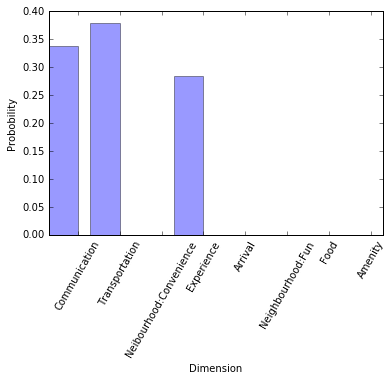

In [60]:
objects = ('Communication', 'Transportation', 'Area:Convenience', 'Experience', 'Arrival', 'Area:Fun', 'Food', 'Amenity')
y_pos = np.arange(len(objects))
performance = norm_output
fig, ax = plt.subplots()

index = np.arange(len(objects))
bar_width = 0.7

opacity = 0.4
#error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, norm_output, bar_width,
                 alpha=opacity,
                 color='b')

plt.xlabel('Dimension')
plt.ylabel('Probobility')

plt.xticks(index + bar_width, ('Communication', 'Transportation', 'Neibourhood:Convenience', 
                               'Experience', 'Arrival', 'Neighbourhood:Fun', 'Food', 'Amenity'))
plt.legend()
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
#plt.tight_layout()
plt.show()

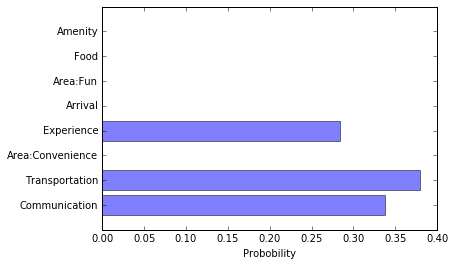

In [76]:
objects = ('Communication', 'Transportation', 'Area:Convenience', 'Experience', 'Arrival', 'Area:Fun', 'Food', 'Amenity')
y_pos = np.arange(len(objects))
performance = norm_output

fig = plt.figure()

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probobility')
#plt.title('Programming language usage')
 
fig.savefig('example_bar.jpg')

In [38]:
## generate chart
custom_style = Style(
background='transparent',
plot_background='transparent',
foreground='#000000',
foreground_strong='#FF9900',
foreground_subtle='#630C0D',
opacity='.6',
opacity_hover='.9',
transition='400ms ease-in',
legend_font_size = 18,
label_font_size = 18,
      
stroke_width = 10,
font_family = "monospace",
guide_stroke_width = 6,
      
      )
  
chart = pygal.Radar(dynamic_print_values=True, style=custom_style, width = 600, height = 600, stroke_style={'width': 4},dots_size = 4, legend_at_bottom = True, legend_at_bottom_columns = 1)
  
chart.x_labels = ['Communication', 'Transportation', 'Area:Convenience', 'Experience', 'Arrival', 'Area:Fun', 'Food', 'Amenity']
chart.add('Your Listing', user_prob, fill = True)
  
chart.render_to_file('sample.svg')

TypeError: unsupported operand type(s) for -: 'int' and 'tuple'